<h1 style="text-align: center;">Cigarras vs. Hormigas: <br> El impacto de la política productiva sobre el Product Space</h1>

---------------------------------

<h3 style="text-align: center;">Modelado y simulación de sistemas complejos aplicados a la economía</h3>

### Universidad de Buenos Aires

Junio del 2024

<img style="float: right;" width="550" src="img/TheProductSpace.png">

**Integrantes:**
- **Valentino Pons** 
  - LU: 614/22
  - Email: valentinopons@gmail.com

- Tomas Ravel 
  - LU: 1497/21
  - Email: tomasravel2002@gmail.com

- Catriel D'Elía 
  - LU: 964/11
  - Email: catriel.delia@gmail.com

- Miguel Fainstein 
  - LU: 23/18
  - Email: miguelon.f98@gmail.com



# Tabla de Contenidos
- **1** Introducción
- **2** Métodos
- **3** Experimentos
    - **3.1** Variación de Omega
        - **3.1.1** Reproducción del paper anterior
        - **3.1.2** Resultados en un sistema de temporalidad variable
    - **3.2** Variación del Lag
    - **3.3** Exploración fija
    - **3.4** Un mundo dividido: Impacto de estrategias para paises periféricos y centrales en la complejidad de los paises
        - **3.4.1** El ECI no permanece estático
        - **3.4.2** Estudio de impacto agregado
- **4** Visualizacíon del Product Space
- **5** Limitaciones de este modelo y próximos trabajos
- **6** Discusión y conclusiones

# 1- Introducción
En el presente trabajo buscamos estudiar el impacto que puede tener para la economía de un país la elección de política productiva. Para ello, llevaremos a cabo un modelo de simulación donde los paises son agentes que deben elegir en cada tiempo discreto, un conjunto de productos que pasaran a ser parte de su base exportable (competitivamente). Esta decisión se verá afectada por dos aspectos de los productos: 
- La *proximidad* del producto, que dicta si un país efectivamente esta en condiciones de desarrollar cierta industria.
- La *complejidad* que en el presente trabajo lo correlacionaremos con el tiempo que tiene que invertir cierto país en el desarrollo de una industria hasta lograr competitividad.
En este contexto estudiaremos dos políticas sencillas y opuestas: una largoplacista y una cortoplacista. Además mostraremos cómo el dinamismo del entorno genera comportamientos complejos y emergencias.

El *Product Space* es un grafo completo de [*proximidades*](https://atlas.cid.harvard.edu/glossary) entre productos exportables. Los nodos representan un producto y las aristas que los unen expresan la proximidad entre estos. Informalmente se entiende por *proximidad* la capacidad (o probabilidad) de que un país exporte cierto producto dado que exporta algún otro. Por ejemplo, si un país exporta lana, probablemente tiene condiciones para exportar textiles; y por lo tanto la lana y los textiles tienen una proximidad *alta*.
Por otro aldo la [*complejidad*](https://atlas.cid.harvard.edu/glossary) de un producto es, también informalmente, una métrica de cuanta sofistición y *know how* require un país para poder producir un producto. 

Esta red ha demostrado ser muy útil para la investigación y los analisis socio-económicos. En particular, [*"Dynamics matter: A simulation framework to study diffusion processes on a Dynamic Product Space"*](https://cnet.fi.uba.ar/netscix23/abstracts/Dynamics%20matter:%20A%20simulation%20framework%20to%20study%20diffusion%20processes%20on%20a%20Dynamic%20Product%20Space.pdf) sirvió como punto de partida de este trabajo. Aquí se estudia un modelo de agentes sencillos que representan los diferentes paises del mundo. Cada país parte con una base de productos en los cuales tienen ventaja competitiva en el comercio global, y en cada iteración aumenta estos productos en función de la proximidad dada por el grafo subyacente. El paper mencionado mostró que al utilizar un entorno dinámico que cambia a lo largo de las iteraciones, se alcanza un comportamiento complejo del sistema. Este dinamismo esta dado por la modificación de las proximidades del grafo, computadas a partir del escenario de competitividades alcanzado en cada iteración. En otras palabras, como los paises aumentan sus productos exportados en cada iteración las proximidades entre productos tambien se ven alteradas, lo que media las intereacciones agente-agente, típicas de los sistemas complejos.

En el paper anterior, los paises desarrollan en cada iteración todos los productos que se encuentran en su frontera. Donde entendemos por "frontera" de productos de un cierto país a los nodos del grafo del *Product Space* que son vecinos a los productos en los cuales este país tiene ventaja competitiva. Es decir que los agentes no deben realizar ninguna elección, sino que su comportamiento esta absolutamente dictado por su entorno. Además el modelo no contempla de ninguna manera la dificultad que conlleva para un país el desarrollo de cierta producción. Sin embargo, es esperable que el empeño (por ejemplo de capitales o de tiempo) para el desarrollo de baterías de iones de litio sea mayor que el empeño realizado por un país para la producción de tornillos.

Teniendo en cuenta estos dos aspectos mencionados, realizaremos dos modificaciones al modelo original para estudiar la política productiva de los paises:
1. Cada país debe elegir un porcentaje fijo de los productos de su frontera a desarrollar en cada iteración. Utilizaremos un porcentaje del 10\% para la mayor parte de nuestros experimentos. La elección de esos productos va a estar dada por la política del país.
2. El desarrollo de los productos ya no es inmediato, sino que los paises tardan una cantidad de iteraciones proporcional a la *complejidad* del producto para ser competitivos en su exportación. La *complejidad* es otra métrica similar a la *proximidad* utilizada en los trabajos originales de *Product Space* por Hidalgo y asociados.

Con estos dos cambios en mente, investigaremos políticas cortoplacistas (que llamaremos Cigarras) y largoplacistas (que llamaremos Hormigas). Las primeras buscan desarrollar aquellos productos cuya complejidad sea menor, logrando incrementar la cantidad de productos que exporta competitivamente en el menor plazo posible. Las segundas realizan el comportamiento opuesto, desarrollando primero aquellos productos cuya producción conlleva más tiempo. Para analizar el impacto de estas políticas realizaremos diferentes experimentos, donde todos los paises tienen politicas homogeneas y otros experimentos con políticas heterogeneas. Además realizaremos experimentos mostrando que el sistema muestra un comportamiento complejo y por último estudiaremos el impacto de los diferentes parámetros utilizados en el modelo.

# 2- Métodos
Para la implementación de este trabajo, decidimos utilizar un esquema orientado a objetos. Con este objetivo, desarrollamos las funcionalidades separadas en dos super clases principales: 
1. *Simulador*: La clase que lleva a cabo las iteraciones y la dinámica de simulación.
2. *Pais*: Clase que implementa el comportamiento de los agentes.

Estas clases están definidas en  ```/src/lib/simulador.py``` y ```/src/lib/agente.py```, acá mostramos algunas secciones interesantes

El comportamiento de cada tiempo de la simulación es el siguiente:
1. Cada país analiza su frontera de productos y elige un subconjunto de los mismos para *investigar*. Usamos el término *investigar* para referir a los productos que fueron elegidos para desarrollar pero que podrían aún no ser exportables debido al tiempo que se debe esperar, dado por su complejidad. Por ejemplo, si un producto conlleva 4 iteraciones hasta lograr la competitividad.
2. Se avanza un tiempo de simulación, los paises actualizan su estado aumentando sus productos competitivamente exportables si es que las investigaciones finalizaron.
3. Por último se recomputa el grafo de proximidades y la matriz de complejidades de productos.

El código que lleva a cabo cada iteración es el siguiente:

```python
class Simulador:
    def iterar_simulacion(self, collector = default_collector) -> Iterator[Dict[Country_Name, HS4_Product_Id]]:
        """Devuelve un iterador para poder simularlo por pasos.
        Toma una función (output:dict, pais, productos alcanzados en esta iteración)
        que permite cambiar que devuelve el simulador
        """
                
        while not self.es_fin_de_simulacion():
            output = {}
            # fase de decisiones
            for pais in self.paises():
                nuevos_productos = pais.elegir_productos()
                for pid in nuevos_productos:
                    pais.investigar_producto(pid)
            # fase de acciones
            for pais in self.paises():
                terminados = pais.avanzar_tiempo()
                collector(output, pais, terminados)
                pais.actualizar_exportaciones(terminados)

            self._actualizar_estado(output)
            self._notificar_paises()
            yield output

```     

Además el método de Pais **investigar_producto**:

```python
    def investigar_producto(self, pid: HS4_Product_Id) -> Tiempo:
        if pid in self._investigando_dict:
            return self._investigando_dict[pid]
        tiempo = self.tiempo_para_ser_competitivo(pid)
        self._investigando_dict[pid] = tiempo
        return tiempo
```

usa el métido **tiempo_para_ser_competitivo** para obtener la cantidad de interaciones necesarias para desarrollar un producto.

Luego al final de la fase de decisiones y de acciones, se notifica a los paises. Ese método del simulador se encarga de redistribuir estado compartido por los paises que ha sido modificado por la iteración actual.

De esto se desprenden lo siguiente:
- es posible obtener distintos comportamientos de paises, subclasificando y modificando **tiempo_para_ser_competitivo** y **elegir_productos**
- es posible obtener simuladores estáticos o dinámicos, según como se implemente **_actualizar_estado** y **_notificar_paises**
- en principio, una vez decidido un tiempo que llevará una investigación de un producto por un país, esta no cambia durante lo que tarda en "investigar" el producto

# 3- Experimentos
## 3.1- Variación de Omega
*Esta sección está basada en los experimentos en:* ```/src/diferencia-estatico-dinamico.ipynb```

De forma similar al paper anterior primero buscamos estudiar si la dinámica del modelo efectivamente describe un sistema complejo con emergencia de comportamientos.

Para ello comparamos la diferencia de productos descubiertos si el sistema es o no dinámico, variando el parámetro umbral $\Omega$. Este parámetro indica el umbral sobre el cual consideramos que los paises pueden desarrollar competitividad en cierto producto, dada la matriz de proximidad. Formalmente, un producto $p$ es alcanzable desde un producto $p'$ si la proximidad $w_{p \rightarrow p'} \geq \Omega$. Notar que si el valor del umbral es 0, todos los productos son alcanzables, y por lo tanto es esperable que no exista diferencia entre un modelo dinámico y uno estático. Equivalentemente, si el umbral es mayor a la máxima proximidad presente, entonces ningun producto es alcanzable y el sistema sufre del mismo problema. Ya que las proximidades no disminuyes y no podría pasar que el modelo dinámico, deje de presentar como alcanzables algunos de los productos.

Además compararemos el sistema utilizando un modelo estático, donde la matriz de proximidades no se actualiza en cada iteración y otro dinámico donde la matriz *sí* se actualiza. Dado que los agentes no interactuan entre si directamente, sino que lo hacen a través del entorno, este experimento es esencial para demostrar que efectivamente estamos trabajando con un sistema complejo ya que si ambos escenarios dieran el mismo resultado significaría que la interacción entre agentes no genera ningún tipo de emergencia.

Mostraremos evolución, tomando dos paises distintos, Argentina y Alemania. Elegimos estos paises ya que la Argentina es nuestro país y por lo tanto nos genera particular interes, y Alemania porque es un típico ejemplo de economía desarrollada y exitosa en términos productivos. Además, en un primer lugar reproducieremos algunos resultados del trabajo del que partimos que utilizan como casos modelo estos dos paises.

In [2]:
from IPython.display import Image

### 3.1.1- Reproducción del paper anterior

En esta sección usaremos nuestro modelo, para primero replicar los resultados del paper citado.

en ```src/lib/simulador.py``` definimos dos simuladores, uno estático que no notifica a los paises del cambio en la matriz de proximidades y otro que si:

```python
class SimuladorEstatico(SimuladorProductSpace):
    def _notificar_paises(self):
        pass  # no hace falta hacer nada, porque no hay modificación


class SimuladorDinamico(SimuladorProductSpace):
    def _actualizar_estado(self, _):
        self.proximidad = ecplx.proximity(self.M)
        super()._actualizar_estado(_)

    def _notificar_paises(self):
        for p in self.paises():
            p.conocer_estado_del_mundo(proximidad=self.proximidad)
```

y además la simulación usará paises cuya frontera de productos sean los alcanzable por el umbral de proximidad y su método de elección de productos será dicha frontera:

```python
class PaisConContaProximidadMixin

    def frontera_de_productos_df(self) -> DataFrame:  # [HS4_Product_Id]
        """Todos los productos alcanzables ... ver 
        lib/agente.py:PaisConContaDeProximidad
        """
        ...
        return frontera

    def frontera_de_productos(self) -> List[HS4_Product_Id]:
        return self.frontera_de_productos_df().to_list()
```

A continuación mostramos dos gráficos. El primero muestra la cantidad de nuevos productos descubiertos en función de cada iteración:

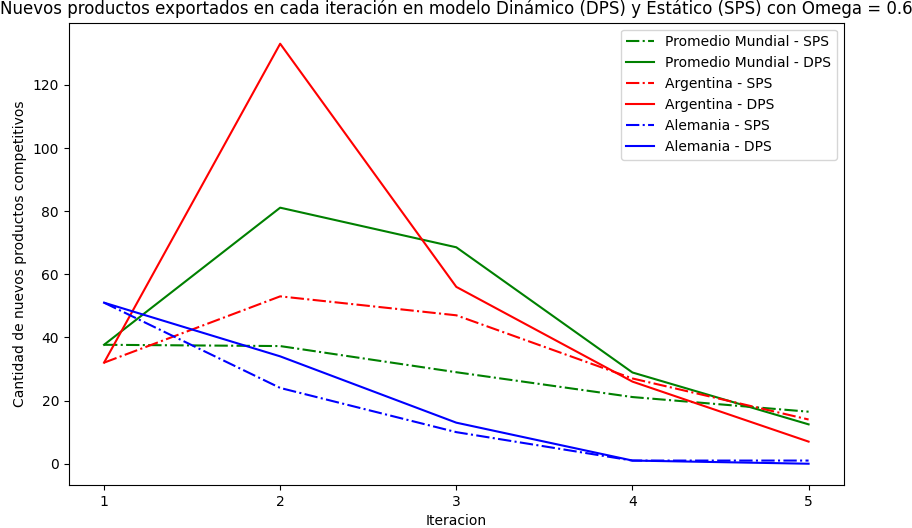

In [2]:
Image(filename='./img/dps-vs-sps-evolucion-productos-paper-omega-0.6.png')

En esta figura se puede apreciar los cambios entre el modelos dinámico y estático para los dos paises elegidos y para un promedio mundial. Lo interesante es que para la elección de dicho umbral de proximidad, se nota una clara diferencia entre los productos descubiertos paso a paso.

Otra característica es que un pais poco complejo como Argentina desarrolla mucho más productos en las primeras iteraciones. La razón puede deberse a que a diferencia del trabajo que estamos replicando en esta sección, los datos son distintos, de años posteriores, y en estos Alemania puede empezar con una proporción de productos ya producidos mayor, dejando pocos productos a ser descubiertos. Dejamos para la discusión este detalle y para trabajos posteriores una comparación de la evolución de paises. 

Finalmente lo util de esta simulación, es ver que al igual que [1](https://cnet.fi.uba.ar/netscix23/abstracts/Dynamics%20matter:%20A%20simulation%20framework%20to%20study%20diffusion%20processes%20on%20a%20Dynamic%20Product%20Space.pdf) hay ciera convergencia luego de unas pocas interaciones.

En este siguiente gráfico:

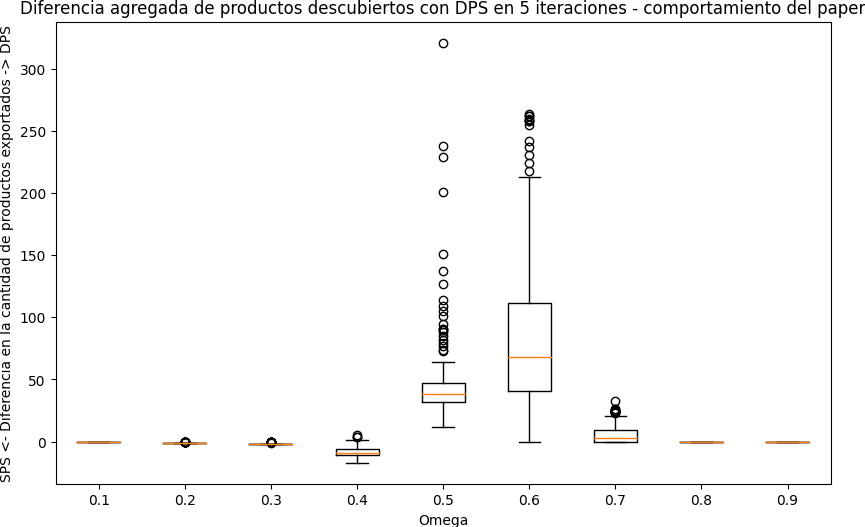

In [3]:
Image(filename="./img/dps-vs-sps-boxplot_comportamiento-del-paper-it_5.png")

hayamos un resultado muy parecido al obtenido por [1](https://cnet.fi.uba.ar/netscix23/abstracts/Dynamics%20matter:%20A%20simulation%20framework%20to%20study%20diffusion%20processes%20on%20a%20Dynamic%20Product%20Space.pdf) en el cual se muestra en un box-plot, la diferencia agregada de productos descubiertos a nivel mundial, luego de 5 iteraciones, para las cuales los paises convergen en cantidad de nuevos productos desarrollados.

Esto muestra que al igual que le papser anterior, valores entre 0.5 y 0.7 son los adecuados para que exista una diferencia entre un modelo dinámico y uno estático.

Finalizamos esta sección, recordando los gráficos del trabajo referenciado, a modo de comparación:

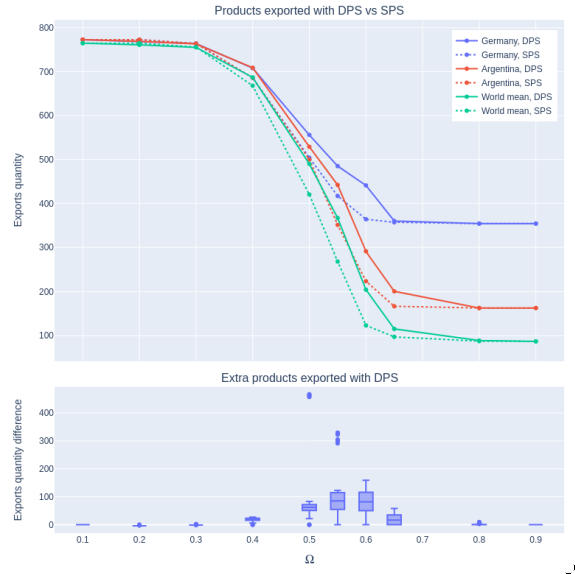

In [4]:
Image(filename="./img/paper-original.png")

### 3.1.2- Resultados en un sistema de temporalidad variable

Ahora nos interesa replicar este mismo esquema investigativo, pero agregando un cambio adicional al modelo, de los dos propuestos.

Vamos a definir un PaisComplejo, como aquel que toma en cuenta la complejidad para saber el tiempo que necesita para ser competitivo, como se ve en el siguiente snippet de código:

```python
class PaisNaive(PaisBaseMixin, PaisConCotaProximidadMixin, IPais):
   ...
    def tiempo_para_ser_competitivo(self, pid: HS4_Product_Id) -> Tiempo:
        return 1
    ...

class PaisComplejo(PaisNaive, IPais):
    ...

    def tiempo_para_ser_competitivo(self, pid: HS4_Product_Id) -> Tiempo:
        """ basicamente tomo las complejidades de productos, si la máxima es M,
        la mínima es m y el tiemp máximo es T;
        genera un mapeo lineal entre T*m/M y T+T*m/M.
        Es decir si T=10 el producto menos complejo tarda 10*m/M iteraciones,
        el más complejo 10 + 10*m/M.
        f(x) = xT / M + Tm/M = T(x+m)/M"""
        x = self.PCI.loc[pid]
        T = self.tiempo_maximo
        M = self.max_pci
        m = self.min_pci
        return np.ceil(T * (x + np.abs(m)) / M)

    ...
    def conocer_estado_del_mundo(self, **kwargs):
        self.mi_eci = kwargs["eci"]
        self.PCI = kwargs["PCI"]
        super().conocer_estado_del_mundo(**kwargs)
```

además de forma similar al experimento anterior, tendremos *SimuladorComplejoEstatico* y *SimuladorComplejoDinamico*. La diferencia de estos es que también se encargad de notificar a los paises de la matriz de complejidad. La diferencia entre ambos es la misma que entre los dos anteriores, el estático, no solo no actualiza la matriz de proximidad si no que tampoco la de complejidad. (ver `informe.py` y `lib/simulador.py`)

Notar en el código anterior usamos un parámetro **tiempo máximo**, esto es la cantidad de iteraciones que lleva descubrir o ser competitivo un producto de complejidad máxima, según las condiciones iniciales de la simulación.

La elección del número está desarrollada en otra sección, aquí solamente diremos que dado que en el paper citado, y en los expermientos replicados con anterioridad, la convergencia está en el orden de las unidades (3-5 iteraciones aprox), pero dado que e **tiempo máximo** es de 10, nuestros agentes pueden tardar hasta un máximo de $10$ iteraciones en alcanzar un producto muy complejo, en este trabajo se iterara **diez veces esa cantidad**.

Mostramos el resultado a continuación, el cual presenta una forma bastante simililar:

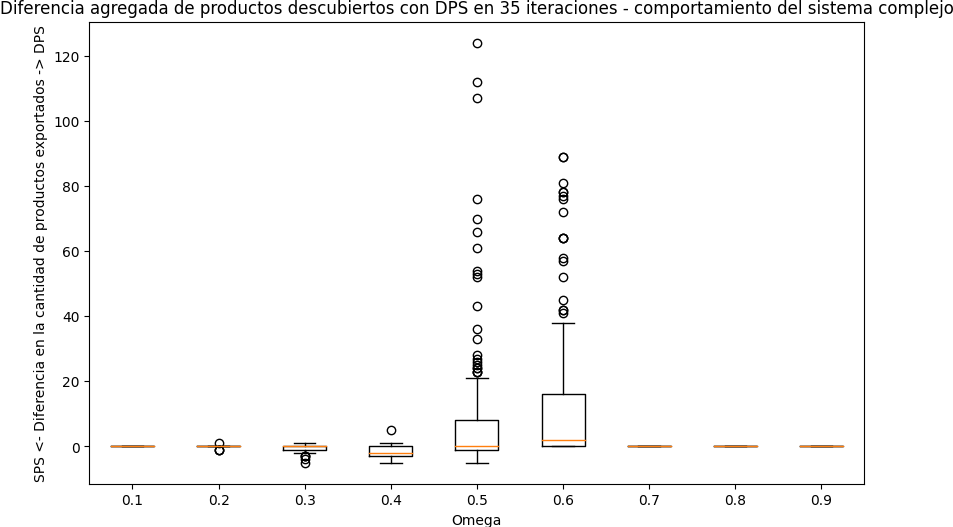

In [5]:
Image(filename="./img/dps-vs-sps-boxplot_comportamiento-del-sistema-complejo-it_35.png")

En el resto de este trabajo usaremos valores de omega entre $0.5$ y $0.6$

## 3.2- Variación del Lag

Código en ```/src/lag.ipynb```

Aqui experimentamos como cambia la simulación al variar el tiempo que tienen que esperar los paises para desarrollar sus productos.
El tiempo de espera por producto es $ \left \lceil \Delta * \overline{\text{PCI}} \, \right \rceil$, donde $\overline{\text{PCI}}$ es la complejidad del producto normalizada entre 0 y 1.

El valor de la variable $\Delta$ representa la cota máxima de espera para los productos. Es decir, el producto más complejo cuya complejidad tenga un $\text{PCI} = 1$ llevará $\Delta$ iteraciones para desarrollarse. Esto naturalmente implica que la simulación requiere más iteraciones para converger.

Para realizar esta experimentación fijamos el valor del parámetro $\Omega$ en 0.55 y ejecutamos la simulación hasta la convergencia para paises hormigas y para paises cigarras (es decir, dos simulaciones independientes en las cuales todos los paises utilizan la misma estrategia), con diferentes valores de $\Delta$.

En la siguiente figura se puede observar que si el $\Delta$ es igual a 1, la política cortoplacista y la largoplacista generan los mismos resultados. Es decir que la complejidad de los productos no altera considerablemente el éxito de los paises, en términos de cantidad de productos exportados competitivamente.

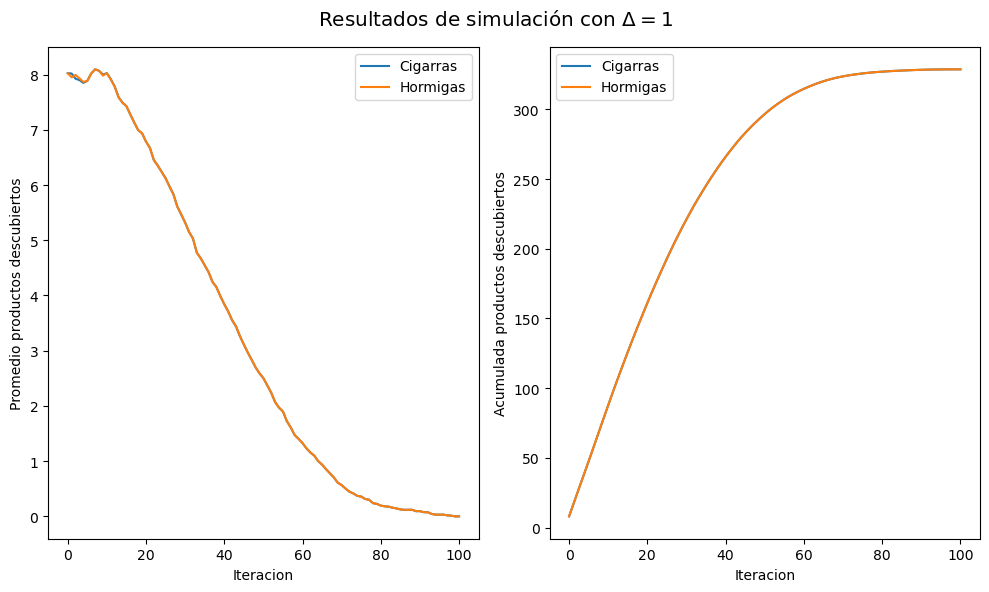

In [6]:
Image(filename="./img/lag_1.png")

Sin embargo, al aumentar el valor de $\Delta$ a 5, 10, 20, 50 o 100; podemos ver dos comportamientos interesantes. Por un lado los paises cigarras muestran un comportamiento uniforme con una pendiente negativa, y por otro lado los paises hormiga muestran un comportamiento periódico dado por los cíclos de desarrollo de los productos investigados. Intuitivamente, los paises hormigas tardan en promedio $\Delta$ iteraciones en generar los primeros desarrollos. A lo largo de las iteraciones, los productos disponibles tienden a tener menor complejidad y por lo tanto esta espera se acorta, aumentando la frecuencia de las oleadas de descubrimientos. Además la cantidad de productos descubiertos decrece (sin tener en cuenta la periodicidad) a un ritmo más veloz que el de las cigarras.

Notablemente, en las figuras de la derecha que muestran la acumulada de productos promedio por pais, podemos ver que los paises cigarra comienzan con ventaja debido a su política cortoplacista. Sin embargo, en todos los casos llega un punto (que se atrasa a medida que aumenta el $\Delta$) en el cual las hormigas superan a las cigarras, y alcanzan la convergencia más rapidamente.

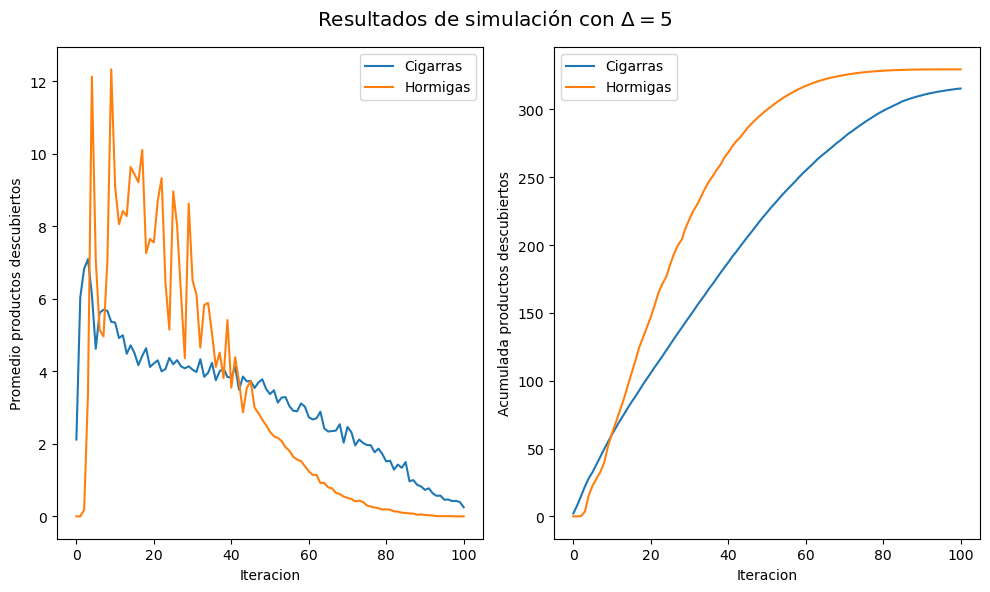

In [7]:
Image(filename="./img/lag_5.png")

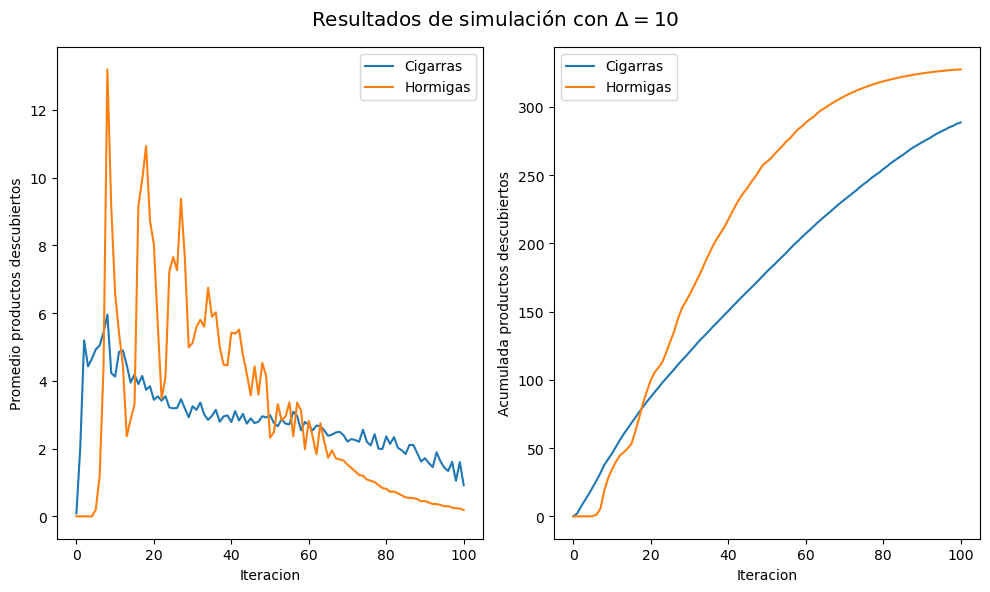

In [8]:
Image(filename="./img/lag_10.png")

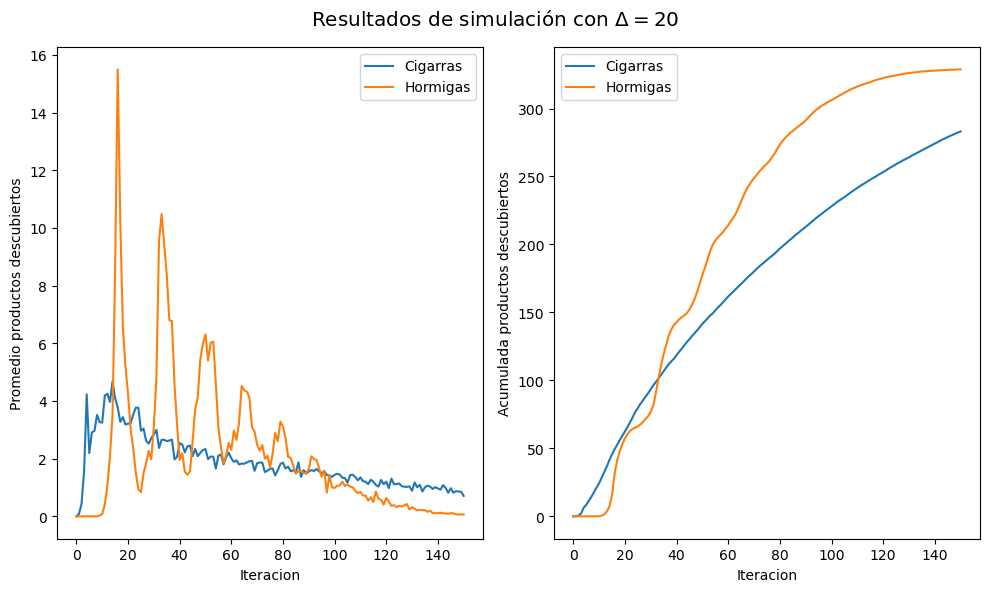

In [9]:
Image(filename="./img/lag_20.png")

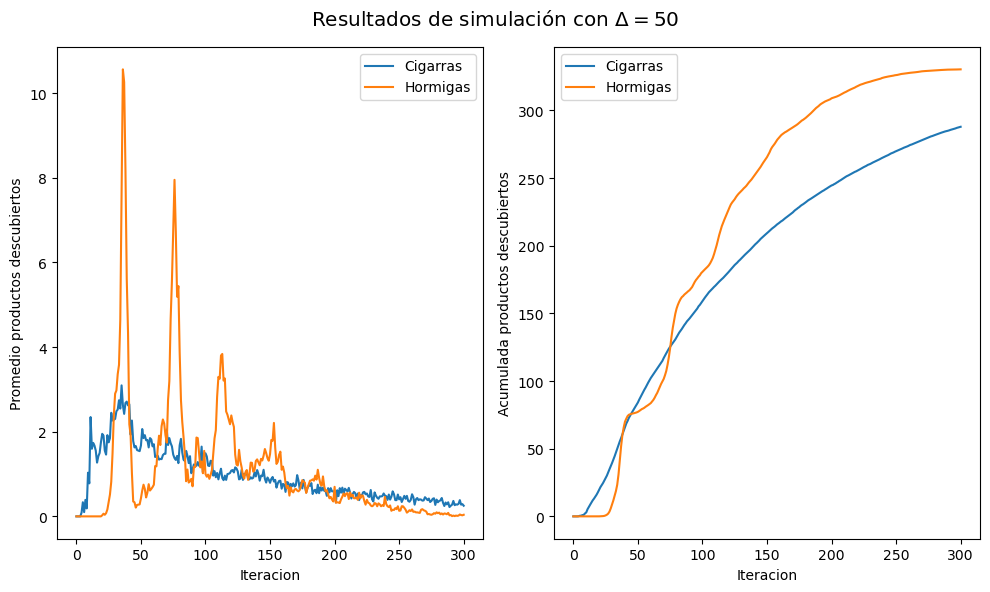

In [10]:
Image(filename="./img/lag_50.png")

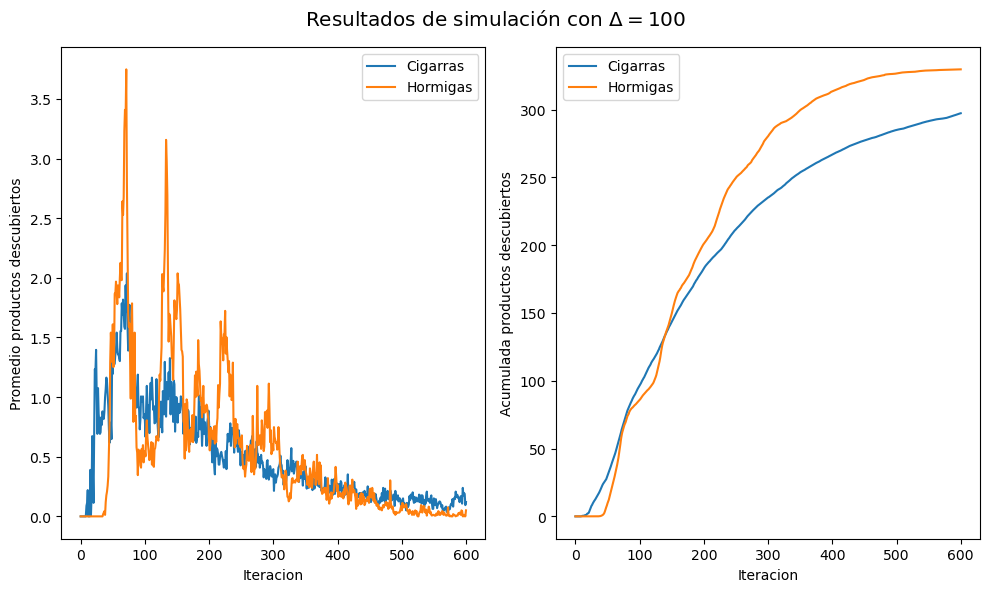

In [11]:
Image(filename="./img/lag_100.png")

## 3.3- Exploración fija

Código en ```/src/lag.ipynb```

Los resultados del experimento anterior pueden interpretarse como que investigar productos que incrementen el tamaño de la frontera visible de productos es particularmente importante. Incluso cuando los productos que más beneficio proveen en este aspecto requieren muchas iteraciones de desarrollo. Sin embargo, hay otro lugar de nuestro modelo donde estamos premiando este comportamiento, lo cual podría estar sesgado positivamente a los paises *hormiga*.

En nuestro modelo inicial, en cada iteración los paises *hormiga* y los paises *cigarra* eligen un 10% de su frontera de productos para desarrollar. Al expresar este comportamiento como un porcentaje estamos beneficiando a las estrategias que hagan crecer la frontera más rapidamente, esto podría estar ayudando especialmente a las *hormigas*.

Para este experimento estudiaremos cómo cambian los resultados si los países desarrollan una suma fija de productos, sin importar el tamaño de su frontera. Utilizamos un valor de $\Omega$ de 0.55 al igual que en el experimento anterior, y un $\Delta$ de 10.

La variable $\phi$ (phi) determina la cantidad de productos desarrollados por iteración. Los paises hormigas entonces eligen los $\phi$ productos más complejos, mientras que los cigarras eligen los $\phi$ más sencillos.

```python

class PaisHormigaFijo( PaisComplejo ):
    def __init__( self, phi, *args, **kwargs ):
        self.phi = phi
        super().__init__( *args, **kwargs )

    def elegir_productos(self) -> List[HS4_Product_Id]:
        tiempos = self.tiempos_para_ser_competitivo()

        if len(tiempos) == 0:
            return []

        return tiempos.nlargest( min(len(tiempos), self.phi) ).index.to_list()


class PaisCigarraFijo( PaisComplejo ):
    def __init__( self, phi, *args, **kwargs ):
        self.phi = phi
        super().__init__( *args, **kwargs )

    def elegir_productos(self) -> List[HS4_Product_Id]:
        tiempos = self.tiempos_para_ser_competitivo()
        
        if len(tiempos) == 0:
            return []

        return tiempos.nsmallest( min(len(tiempos), self.phi) ).index.to_list()
```

Con $\phi=1$ el resultado es ruidoso ya que la cantidad de productos desarrollables es muy chica. En este caso las hormigas no logran una ventaja por sobre las cigarras e incluso se colocan siempre un poco por detras de ellas en términos de cantidad de productos exportados competitivamente.

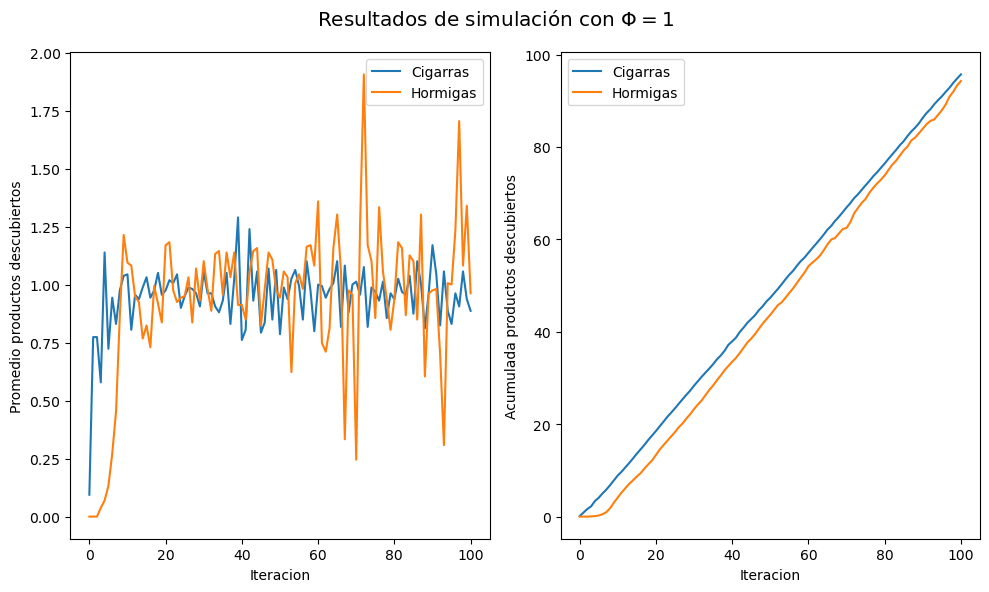

In [12]:
Image(filename="./img/phi_1.png")

Al utilizar valores de $\phi$ más grandes (10 y 100), vemos comportamientos similares. En el caso de $\phi=10$ vemos que las hormigas muestran una leve ventaja por sobre las cigarras, sin embargo lejos de los valores que observabamos al usar desarrollos variables según el tamaño de la frontera como en el experimento anterior. Y en el caso de $\phi=100$ vemos un comportamiento casi identico entre ambas políticas.

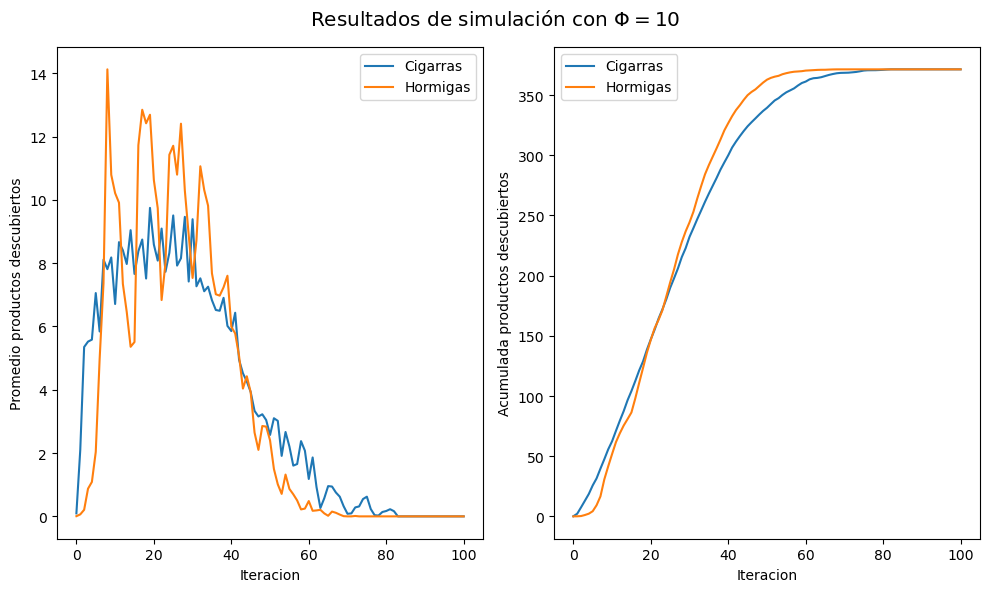

In [13]:
Image(filename="./img/phi_10.png")

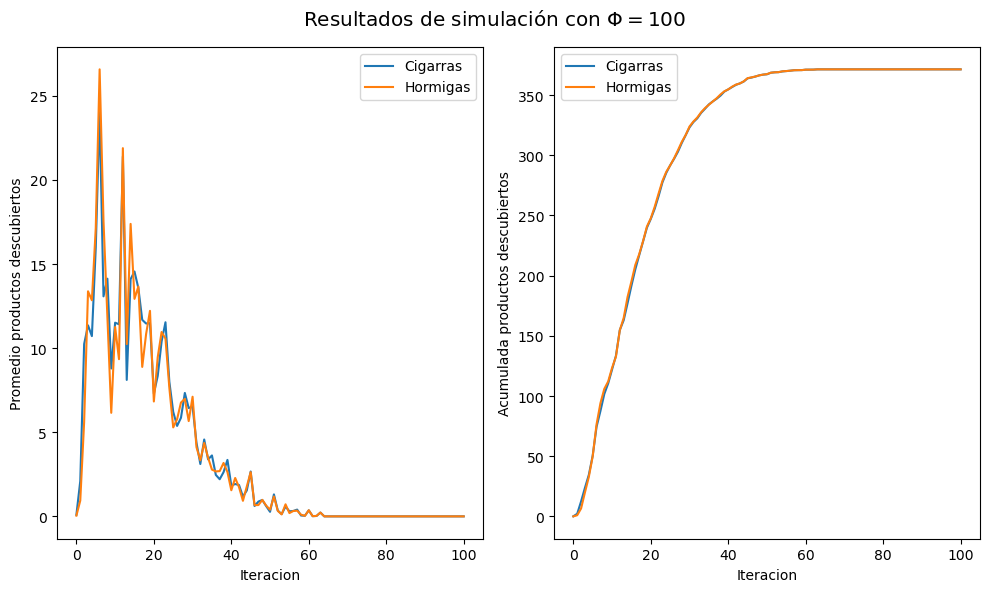

In [14]:
Image(filename="./img/phi_100.png")

Este experimento demuestra que la ventaja de desarrollar productos más complejos es justamente que estos hacen crecer la frontera de productos accesibles más rápidamente. Al eliminar esta ventaja, la diferencia entre políticas cortoplacistas y largoplacistas no parecen tener tanto impacto.

Por lo tanto, esto podría indicar que en un modelo donde los paises tuvieran capacidad fija para desarrollar productos (ya sea a través del modelado de capitales u restricciones externas, entre otras), las políticas largoplacistas podrían no ser necesariamente superiores a las cortoplacistas.

## 3.4- Un mundo dividido: Impacto de estrategias para paises periféricos y centrales en la complejidad de los paises

En esta sección exploraremos la última de las modificaciones propuestas al trabajo original. Nos interesa comparar la evolución de la complejidad según las distintas estrategias. Para eso difinimos dos tipos de paises complejos: un país largoplacista (hormiga) eligirá para desarrollar el 10% de los productos más complejos de su frontera, mientras que un país cortoplacista (cigarra) eligirá el 10% más sencillo:

```python
class PaisHormiga(PaisComplejo):
    def elegir_productos(self) -> List[HS4_Product_Id]:
        "selecciona los primeros 10% de productos más complejos de su frontera"
        tiempos = self.tiempos_para_ser_competitivo()

        if len(tiempos) == 0:
            return []

        return tiempos.nlargest(int(len(tiempos) * 0.1)).index.to_list()


class PaisCigarra(PaisComplejo):
    def elegir_productos(self) -> List[HS4_Product_Id]:
        "selecciona los últimos 10% de productos más complejos de su frontera"
        tiempos = self.tiempos_para_ser_competitivo()
        
        if len(tiempos) == 0:
            return []

        return tiempos.nsmallest(int(len(tiempos) * 0.1)).index.to_list()
```

en ```src/lib/informe.py```

## 3.4.1- el ECI no permanece estático

En esta sección corremos unos experimentos que muestran que el ECI no permanece estático a lo largo de la simulación y que es de interés hacer análisis posteriores.

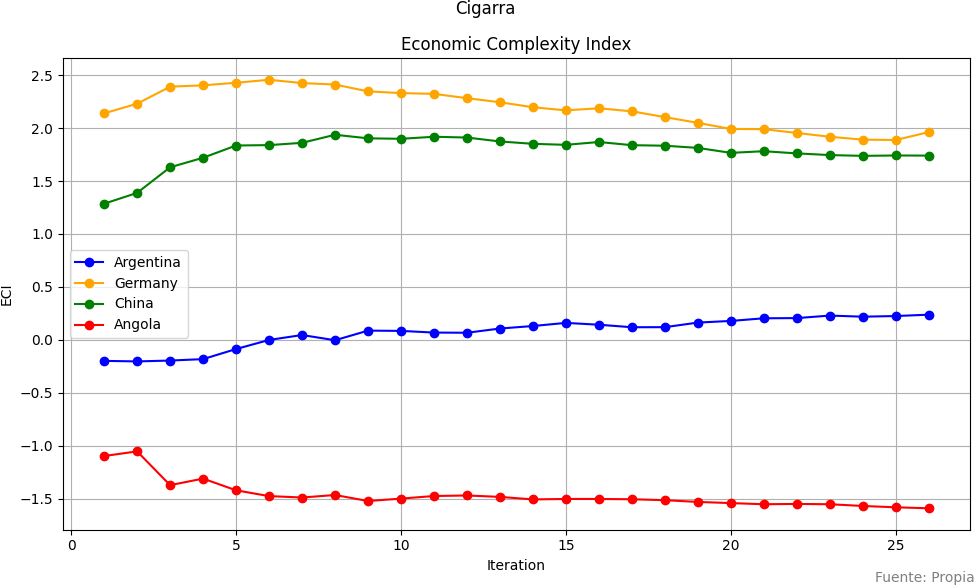

In [15]:
Image(filename="./img/evolucion-eci-cuatro-paises-cigarra.png")

Se decidió registrar el Índice de Complejidad Económica (ECI) de un conjunto de países seleccionados y se midió cómo este iba cambiando a lo largo de las iteraciones. Los países elegidos fueron Argentina, Alemania, China y Angola, y la selección se basó en la diversidad de sus economías y complejidades iniciales.

Al principio, puede parecer inesperado que el ECI disminuya, como es el caso de Angola, ya que uno podría pensar que, a lo largo de las iteraciones, todos los países conquistan nuevos productos y el índice debería aumentar. Sin embargo, el ECI no se mide localmente en cada país, sino que es un parámetro que depende de la economía mundial y de las exportaciones de otros países. Por lo tanto, en un contexto donde un país no crece tanto en relación con sus competidores, es posible que su ECI descienda.

Argentina, al comenzar con un ECI cercano a 0, muestra un crecimiento a lo largo de las iteraciones. Angola, por otra parte, encuentra dificultades para complejizar su economía en comparación con otros países debido a sus condiciones iniciales más complicadas.

China es uno de los países que más crecen en las primeras iteraciones. La combinación de empezar con un ECI positivo pero no demasiado elevado induce a un rápido crecimiento, ya que las conexiones de sus productos conquistados se enlazan con zonas del grafo más complejas y densas. Alemania sufre algo similar.

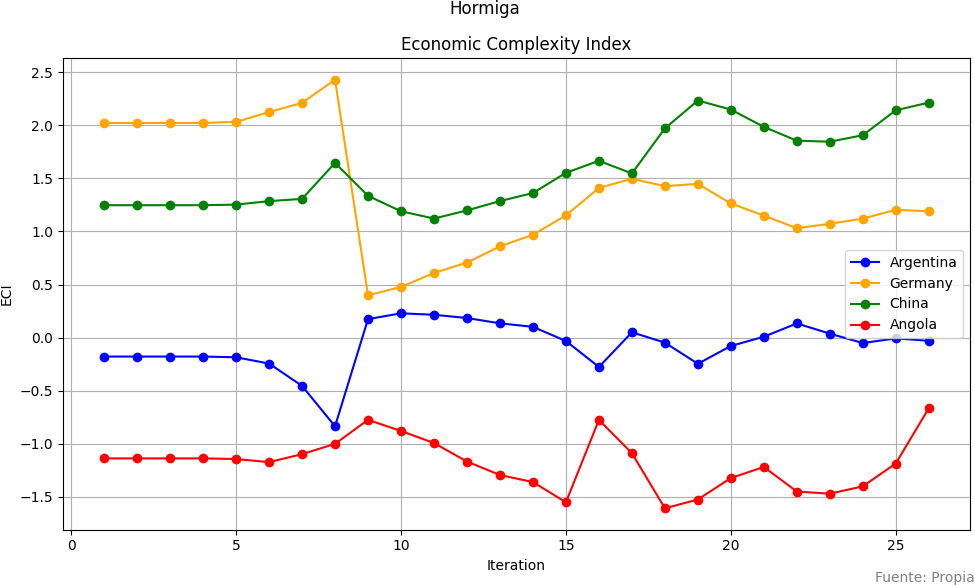

In [16]:
Image(filename="./img/evolucion-eci-cuatro-paises-hormiga.png")

Cómo se puede ver en este último gráfico con respecto al anterior, hay dos diferencias notables:
- la evolución de la complejidad presenta un aspecto de diente de cierra. Esto puede deberse a que al cambiar a una estrategia largo placista, los paises acumulan productos investigando, que luego aparecen como un shock.
- hubo una inversión de la complejidad entre China y Alemania, que luego de una caida importante al rededor de la iteración $8$ nunca pudo volver a superar a China. En el caso de paises con estrategia puramente cortoplacistas, dichas inversiones no se ven y si bien, hay cambio en las distancias, el orden de paises según complejidad, es siempre el mismo.
- Es notable la brusca caída que experimenta Alemania después de la iteración 8. Alemania parte de una base donde ya es experta en diversas áreas complejas, por lo tanto, al adoptar una estrategia de "hormiga", le cuesta más encontrar nuevos productos complejos en cada iteración, ya que la mayoría ya los produce. Por esta razón, aunque crece levemente al principio, a partir de la iteración 7 su ECI cae alrededor de 2 puntos.

## 3.4.2- Estudio de impacto agregado
notebook de experimentos en: ```src/diferencia-complejidad-por-estrategia.ipynb```

En esta sección nos preguntamos como afectará la distribución de las complejidades de los paises, según estas dos estrategias productivas.

Para eso dividiremos a los paises según su complejidad inicial. Como la misma suele venir en una distribución normal ~ (0,1) simplemente dividiremos en paises **centrales**, a aquellos que tengan un $eci > 0$ y **perifericos** en caso contrario, y asignaremos las dos estrategias por un total de cuatro experimentos:

| periféricos | centrales |
|-------------|-----------|
| hormigas    | hormigas  |
| hormigas    | cigarras  |
| cigarras    | hormigas  |
| cigarras    | cigarras  |

que serán ejecutados por cada configuración, con un **omega=0.55** y cantidad de **iteraciones=35** pues fueron los hayados en las sección 3.1.2.

El primer resultado da una idea de la distribución de las complejidades al finalizar los cuatro experimentos.
Usamos las últimas iteraciones, ya que durante el transcurso de la simulación la variación de complejidades es muy grande y de todas maneras solo nos interesa el estado final. Pero por otro lado, usar solo la última iteración puede dar lugar a resultados espureos, no representativos de un comportamiento sistémico y debido principalente al azar.

Resumimos en un boxplot, los resultados de los cuatro experimentos y la distribución inicial:

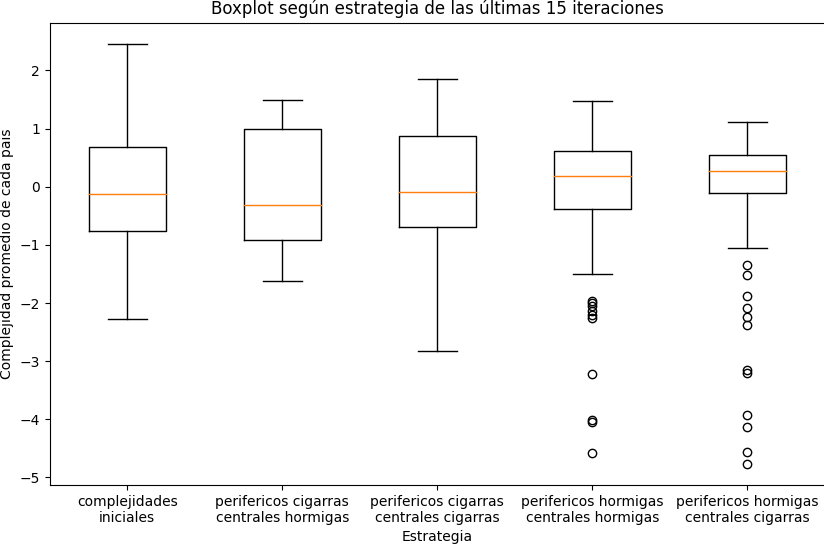

In [17]:
Image(filename='./img/estrategias-boxplot-ultimas-15.png')

Si nos enfocamos en el primer y segundo cuartil, se puede apreciar que hay una tendencia al agrupamiento de las complejidades, con respecto al boxplot correspondiente a la situación inicial a medida que nos movemos hacía la derecha por el gráfico. 

El único que presenta aun más dispersión, es el que los paises centrales tienen comportamiento largoplacista y los periféricos cortoplacista, mientras que a medida que nos movemos hacía la derecha, dicha dispersión disminuye, siendo el boxplot más compacto aquel en que los paises centrales fueron cortoplacistas y los periféricos hormigas. 

No solo eso, si no que comparando el promedio de complejidades, también este último es el que presenta mayor complejidad que todo el resto de los experimentos y su opuesto, el primero después del de complejidades iniciales, presenta una disminución de la complejidad promedio.

También podemos ver, como es el histograma de complejidades, partiendo de las iniciales que se ajusta a una normal:

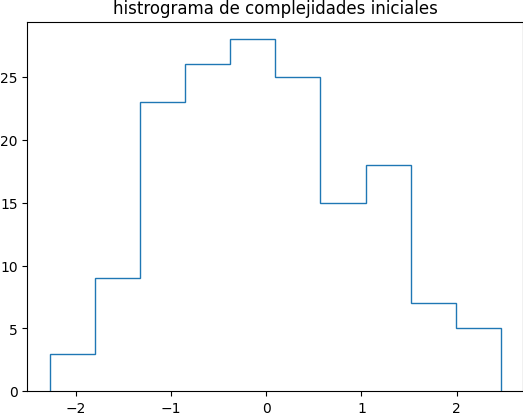

In [18]:
Image(filename='./img/histograma-eci-inicial.png')

mientras que para uno de los experimentos mencionados, la distribución se asemeja a dos distribuciones normales separadas, donde la diferencias ya existentes se amplificaron pero la cantidad de paises de cada lado es similar:

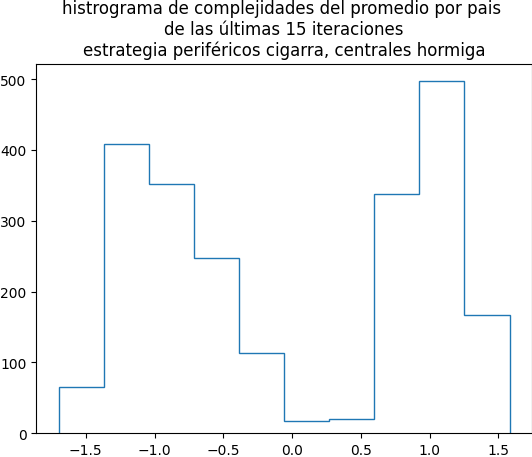

In [3]:
Image(filename='./img/estrategia-histograma-complejidades-camello.png')

en el caso donde los paises periféricos tuvieron políticas largoplacistas y los centrales no, se observa algo bastanten interesante:

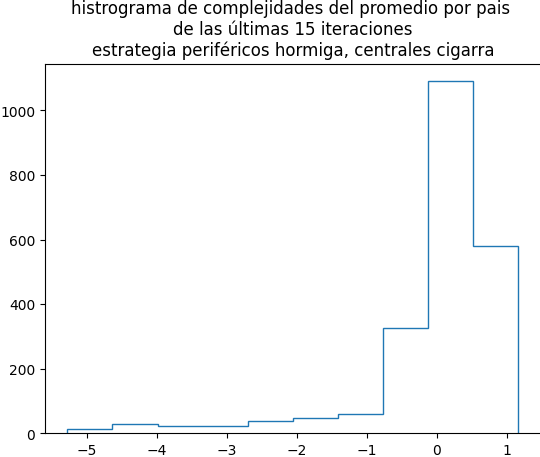

In [4]:
Image(filename='./img/estrategia-histograma-complejidades.png')

 Por un lado parece ser un mundo más unipolar: una normal que agrupa a la mayoría de los datos con poca dispersión, centrada en $0$. 
 Sin embargo hay una división también: aparece una cantidad importante de outliers, que se visualizan tanto en la cola pesada de esta normal asimétrica y en el boxplot mostrado con anterioridad.
No solo eso, si no que esta cola pesada, llega a valores mucho más negativos; con lo cual si bien este experimento parece arrojar un mundo menos dividido, sorprendentemene, hay unos pocos paises poco afortunados, que les va aun peor en este escenario.

Una posible explicación de este comportamiento, es que para el umbral elegido, hay paises que nunca pudieron desarrollarse, por ser muy poco complejos. 

Acá pueden haber entrado dos fenómenos. Por un lado, puede ser un artefacto: las complejidades se calculan relativamente, un país que no hace nada, mientras el resto del mundo avanza, verá su complejidad descender.

Pero por otro lado, puede ser un fenómeno mucho más interesante. Vimos en el comienzo de esta sección, que un cambio brusco puede tener impactos no previsibles, como el cambio en el orden de complejidades entre dos paises no muy distantes (Alemania y China) con complejidades que en la experimentación suave tendían a acercarse pero mantenían su orden de complejidad, mientras que en la simulación con hormigas, los cambios bruscos introducían un shock que producía que China supere a Alemania.

En ese sentido en el histograma donde se ven dos normales, los paises periféricos, acompañaban a los paises con menos ventajas, cambiando su complejidad de forma suave sin cambios súbitos. Esto pudo provocar que el cambio en el grafo vuelva accesible algún producto para los paises que empezaron con menos ventajas comparativas, de tal manera que la diferencia final, enfocándonos en la normal izquierda, no presente esta cola pesada. En cambio, en el caso del último histograma, los paises periféricos que lograban desarrollar productos más complejos, pueden haber actuado como barrera para otros de complejidad inferior o incluso similar.

# 4- Visualizacíon del Product Space

A continuación vamos a mostrar 4 visualizaciones del grafo de productos del Product Space a medida que avanzan las iteraciones. Las 4 visualizaciones surgen de las combinaciones posibles entre visualizar a Argentina o a Alemania y que estos tomen la estrategia Cigarra u Hormiga.
Es un gráfico un tanto distinto a los gráficos tradicionales, principalmente porque no hay información en los ejes x e y (aunque sí hay un significado detrás de la centralidad o ”lejanía” de cada producto en el grafo.). Cada grafo corresponde a un país con una estrategía. Los nodos simbolizan los productos, el tamaño de estos es su complejidad (complejidad inicial porque si incluimos la variación de la complejidad se tornaba realmente difícil de visualizar) y el color representa que tan tarde o temprano el producto fue llevado a producción por el país, donde productos con color más oscuro significa que estos fueron descubiertos más tarde mientras que productos más claros hablan de una más temprana adopción por parte del país. Los nodos grises son los productos que el país producía en un principio. Por cuestiones de simplicidad, se omitieron las aristas entre los nodos. Luego de los 4 gráficos resaltamos algunas observaciones interesantes.

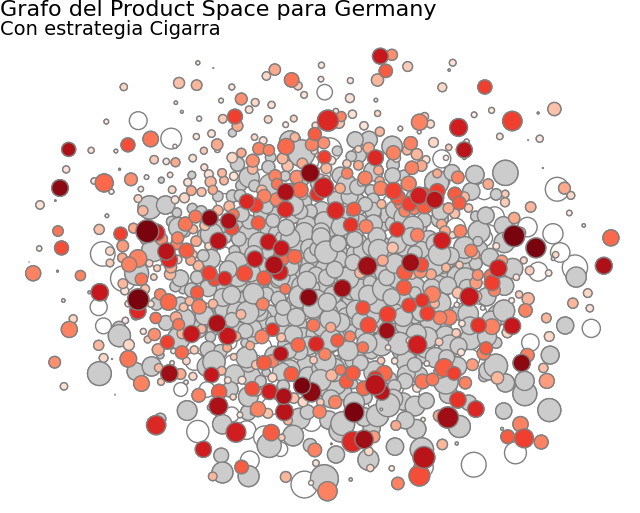

In [3]:
Image(filename='./img/grafo-cigarra_Germany.png')

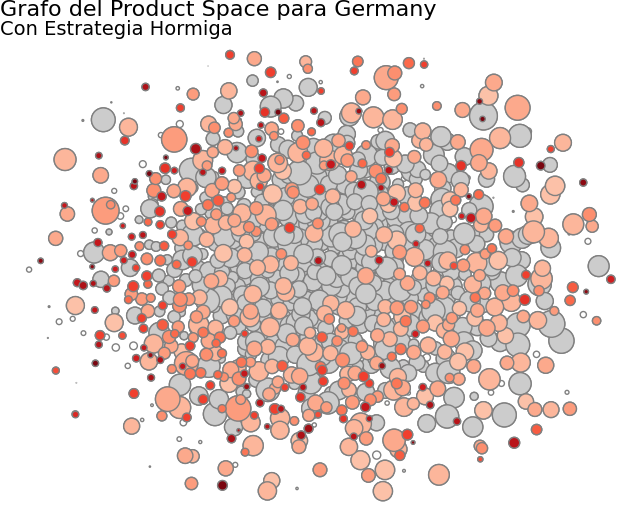

In [4]:
Image(filename='./img/grafo-hormiga_Germany.png')

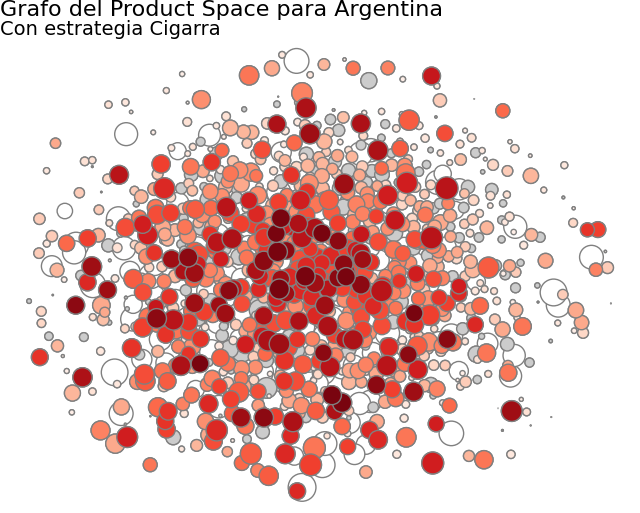

In [5]:
Image(filename='./img/grafo-cigarra_Argentina.png')

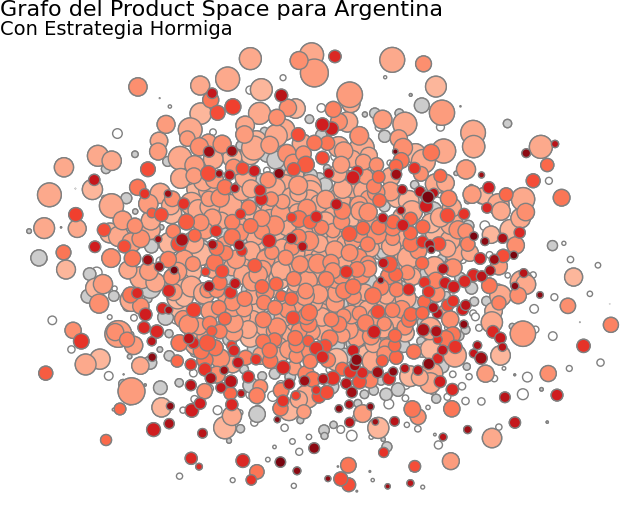

In [6]:
Image(filename='./img/grafo-hormiga_Argentina.png')

Como era de esperar, se puede ver que ambos países obtienen los productos menos complejos antes cuando toman la estrategia cigarra, mientras que en su versión de estrategia hormiga son los nodos más grandes los que están de color más claro
Además, es interesante ver como el grafo de Alemania tiene muchos mas puntos grises que el de Argentina, mostrando la superioridad productiva con la que empieza, ya que no solo comienza con más productos sino que estos son más centrales que los de argentina.
Por ultimo, Argentina termina con más puntos blancos que Alemania, indicando que este termina con más productos fuera de su alcance de producción que Alemania.


# 5- Limitaciones de este modelo y próximos trabajos
- no ponderamos el ECI de cada país para el tiempo de investigación/inversión.
    - Este es la linea de investigación más sencilla. En este trabajo el tiempo que llevará ser competitivo en un nuevo producto, depende solo de la complejidad del producto y no de la complejidad del país. Solo indirectamente, a travez de la proximidad, la diferencia entre paises se manifiesta en el product space. Es decir si bien, es una homogeinización de las diferencias entre los paises, que dos paises paises distintos puedan acceder a un producto nuevo en la misma cantidad de tiempo, se mantiene que un país sin la complejidad suficiente, puede no ver todos los productos que un país complejo ve, entonces en la práctica, el tiempo para llegar a ser competitivo en dicho producto será también diferente, pues el país menos complejo tendrá que llegar a que este producto aparezca en su frontera.
- Los paises no dejan de ser competitivos en un producto al que ya lograron competitividad.
  - Es irreal, es posible que un país pierda competitividad frente a otro que investigó el mismo producto, por alguna razón, por ejemplo, haberse dedicado a impulsar otro producto.
      - Una forma posible de hacer esto, es trabajar con los datos crudos de comercio y hacer que los paises aumenten paulatinamente para algún producto, la cantidad que se exporta, según algún presupuesto.
      - luego al calcular el RCA y su binarizado M, es posible que se pierdan competitividades.
      - en este caso hay que tener en cuenta más parámetros de trabajo, como cual es el presupuesto que se tiene, si es el mismo para todos, si depende de la complejidad de cada país, etc.
- no modificamos la linealidad de la extrapolación temporal
    - Se argumentó que preferimos que la complejidad provenga de interacciones simples, pero puede ser interesante explorar distintas dependencias de la complejidad de un producto, respecto al tiempo que llevaría volverse competitivo en él.
- En 3.1.1 se elijió Alemania, pero al ver la cantidad de productos nuevos descubiertos, estos no parecen crecer a la misma velocidad. Esa diferencia se puede deber a que este país ya empieza con muchos productos ya producidos y luego su frontera es más chica. Una mejora a ese experimento, sería hacer un análisis de complejidad y comparar dos paises simétricos.
- En cada iteración un país puede volver a iniciar una investigación, sin que importe si está o no investigando. Esto es también poco realista, dado que los recursos son acotados. Una forma de lidiar con los resultados de la sección 3.3 podría ser evitar que los paises puedan iniciar nuevas investigaciones en cada iteración o que no puedan iniciar nuevas hasta que no terminen las anteriores.
- En la sección 3.4, aparecieron resultados interesantes que parecen tener que ver con la idea de perturbación o shock, del sistema. Una posible via de investigación es separar el efecto de los shocks, de las estrategias de los paises. Además, aparcen outliers y colas pesadas en dos de los experimentos, siempre que los periféricos, siguen estrategia de hormigas.

# 6- Discusión y conclusiones

A partir de un [trabajo anterior](https://cnet.fi.uba.ar/netscix23/abstracts/Dynamics%20matter:%20A%20simulation%20framework%20to%20study%20diffusion%20processes%20on%20a%20Dynamic%20Product%20Space.pdf) logramos dar los primeros pasos en la exploración de una pregunta de investigación: ¿que impactos tiene en la complejidad de los paises, distintas políticas de elección de productos en un entorno de product space dinámico?

Pudimos reproducir resultados elegidos del trabajo anterior, dando peso tanto al trabajo previo, como al nuestro, usando datos de años posteriores. 
Encontramos algunos resultados no triviales, como el hecho de que una estrategia a largo plazo tiene efectos deseables a la hora de incrementar la complejidad de los paises que la persiguen, o que un mundo más desarrollado y menos polarizado, es el resultado de la persecusión de una estrategía largo placista de los paises menos complejos. Dos resultados que pueden ser interesantes a la hora de policy making.

Desde el punto de vista de los sistemas complejos, en ambos experimentos de un mundo dividido, donde los paises periféricos siguen estrategias largo placistas, aparecen colas pesadas y outliers, de paises que parecen quedar muy atrás en la carrera por la complejidad; un hallmark de fenómenos emergentes en los sistemas complejos. También, vimos la emergencia de resultandos distintos frente a paises que siguen todos la misma política: en la sección 3.4.1 se vió como los mismos paises, al variar su estrategia, en la misma cantidad de iteraciones, pueden cambiar su posición en el podio de complejidades económicas. 

Finalmente en la sección 5, dimos una extensa lista, donde resumimos las limitaciones del modelo, tanto encontradas durante el trabajo, como novedodas, que pueden servir para trabajos posteriores. En particular en la sección 3.2 y 3.3 nos adelantamos a algunas críticas en la elección arbitraria del lag temporal y de la cantidad porcentual de nuevos productos que los paises pueden incorporar en cada iteración; mostrando que el primero no es importante, pero que el segundo debe ser investigado con más detalle.